## 目录
### 1. 问题分析与模型选择
### 2. 数据分析与可视化
### 3. 数据预处理
### 4. 模型训练与验证
### 5. 总结与分析


## 1. 问题分析与模型选择
主题是反欺诈，模型的解释变量和被解释变量如图所示：
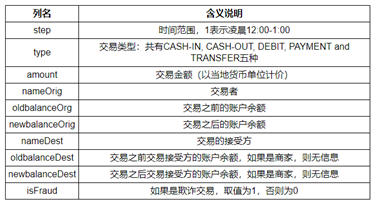
***
是否是金融欺诈数据与交易时间，类型，账户余额等等相关，我们需要注意的是晚上的时间理论上来说是从晚九点到次日早上六点的，也就是说这里不能直接将1-24作为一个数值标量进行计算，而是要需要转换成类型变量，而对于交易类型也需要转换成类型变量做考虑。
所以模型的初步思路是：
1. 根据逻辑和商业背景构建特征
2. 用一个决策树去做分析和理解；

## 2. 数据分析与可视化
本部分包括，各个变量的统计性质的展示，各个变量单独与目标变量的分布相关关系展示，以及一些衍生出来的分析和策略

In [2]:
# 包的调用和数据加载
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error
from sklearn.metrics import roc_curve, auc

In [3]:
path = 'C:/Users/26529/Desktop/XiaoyuDu world/2 CometetionProjects/17 BOYA BIgdata/Interview/data_financial.csv' 
data = pd.read_csv(path)

In [5]:
#数据分析和可视化
print('数据量大小是'+str(len(data))+'行')

数据量大小是574255行


In [6]:
print('五种支付类型所占的比率分别是')
print(data.groupby('type').count()['step']/len(data))
print('在欺诈案例中五种支付类型所占的比率分别是')
print(data[data['isFraud']==1].groupby('type').count()['step']/len(data[data['isFraud']==1]))
print('可以看出在欺诈案例中只存在转账和支付')
print('在非欺诈案例中五种支付类型所占的比率分别是')
print(data[data['isFraud']==0].groupby('type').count()['step']/len(data))
print('很明显的，诈骗只存在于支出之中，接下来我们将现金转出和转账单独取出，避免大量噪声数据干扰统计分析\n\n')

五种支付类型所占的比率分别是
type
CASH_IN     0.215977
CASH_OUT    0.355934
DEBIT       0.007784
PAYMENT     0.339006
TRANSFER    0.081298
Name: step, dtype: float64
在欺诈案例中五种支付类型所占的比率分别是
type
CASH_OUT    0.520295
TRANSFER    0.479705
Name: step, dtype: float64
可以看出在欺诈案例中只存在转账和支付
在非欺诈案例中五种支付类型所占的比率分别是
type
CASH_IN     0.215977
CASH_OUT    0.355689
DEBIT       0.007784
PAYMENT     0.339006
TRANSFER    0.081072
Name: step, dtype: float64
很明显的，诈骗只存在于支出之中，接下来我们将现金转出和转账单独取出，避免大量噪声数据干扰统计分析




In [16]:
# 先将必定不是欺诈的交易类别去除  避免噪声数据太大干扰模型
# 不是欺诈交易的包括三种情况 借记  支付（有对应的商家）  和 收钱
# S is a mask 善用 S.any S.all 这些操作
S = pd.DataFrame()
S['1'] = data['type'] == 'CASH_OUT'
S['2'] = data['type'] == 'TRANSFER'
Data_0 = data[S.any(axis='columns')].copy()
print('筛选后的数据量大小是'+str(len(Data_0))+'行')

筛选后的数据量大小是251083行


In [17]:
S.head()

,1,2
0,False,False
1,False,False
2,False,True
3,True,False
4,False,False


对一天24个小时时间段我们画出这24值的对照图


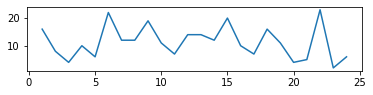

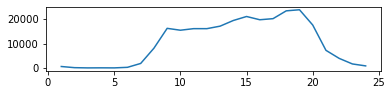

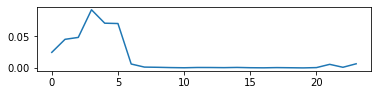

可以看到欺诈案例的发生一直是平稳波动的，而在夜间（0点到5点）由于交易量较少使得发生率较高




In [18]:
print('对一天24个小时时间段我们画出这24值的对照图')
plt.subplot(3,1,1)
plt.plot(Data_0[Data_0['isFraud']==1].groupby('step').count()['type'])
plt.show()
plt.subplot(3,1,2)
plt.plot(Data_0[Data_0['isFraud']==0].groupby('step').count()['type'])
plt.show()
plt.subplot(3,1,3)
plt.plot(np.array(Data_0[Data_0['isFraud']==1].groupby('step').count()['type'])/np.array(Data_0[Data_0['isFraud']==0].groupby('step').count()['type']))
plt.show()
print('可以看到欺诈案例的发生一直是平稳波动的，而在夜间（0点到5点）由于交易量较少使得发生率较高\n\n')

In [19]:
Data_0[Data_0['isFraud']==1].groupby('step').count()['type']

step
1     16
2      8
3      4
4     10
5      6
6     22
7     12
8     12
9     19
10    11
11     7
12    14
13    14
14    12
15    20
16    10
17     7
18    16
19    11
20     4
21     5
22    23
23     2
24     6
Name: type, dtype: int64

In [20]:
print('我们构造一些相对变量来取代绝对变量进行分析')
print('下面我们新构建的变量代表了账户金额的相对变化率，对于0金额账户我们假设其中有100元以避免0为分母情况')
Data_0['ORG_change']=(Data_0['newbalanceOrig']-Data_0['oldbalanceOrg'])/(Data_0['oldbalanceOrg']+100)
Data_0['DEST_change']=(Data_0['newbalanceDest']-Data_0['oldbalanceDest'])/(Data_0['oldbalanceDest']+100)
print('被欺诈账户的平均相对变化率是'+str(Data_0[Data_0['isFraud']==1]['ORG_change'].mean()))
print('非被欺诈账户的平均相对变化率是'+str(Data_0[Data_0['isFraud']==0]['ORG_change'].mean()))
print('欺诈账户的平均相对变化率是'+str(Data_0[Data_0['isFraud']==1]['DEST_change'].mean()))
print('非欺诈账户的平均相对变化率是'+str(Data_0[Data_0['isFraud']==0]['DEST_change'].mean()))

我们构造一些相对变量来取代绝对变量进行分析
下面我们新构建的变量代表了账户金额的相对变化率，对于0金额账户我们假设其中有100元以避免0为分母情况
被欺诈账户的平均相对变化率是-0.9270408286112364
非被欺诈账户的平均相对变化率是-0.43818771306555243
欺诈账户的平均相对变化率是1884.4469323773421
非欺诈账户的平均相对变化率是422.99962032169486


In [21]:
print('接下来我们对剩余的数值变量做一个相关性分析并输出相关系数表')
print(Data_0.iloc[:,[9,2,4,5,7,8,10,11]].corr())
print('所有的变量与isFraud相关系数的符号都符合逻辑')

接下来我们对剩余的数值变量做一个相关性分析并输出相关系数表
                 isFraud    amount  oldbalanceOrg  newbalanceOrig  \
isFraud         1.000000  0.047403       0.098889       -0.001936   
amount          0.047403  1.000000       0.064525       -0.042256   
oldbalanceOrg   0.098889  0.064525       1.000000        0.911447   
newbalanceOrig -0.001936 -0.042256       0.911447        1.000000   
oldbalanceDest -0.012463  0.134083      -0.017745       -0.011356   
newbalanceDest -0.010511  0.258338      -0.010010       -0.014732   
ORG_change     -0.034557 -0.103851      -0.050361        0.082298   
DEST_change     0.021862  0.232531       0.036049       -0.008609   

                oldbalanceDest  newbalanceDest  ORG_change  DEST_change  
isFraud              -0.012463       -0.010511   -0.034557     0.021862  
amount                0.134083        0.258338   -0.103851     0.232531  
oldbalanceOrg        -0.017745       -0.010010   -0.050361     0.036049  
newbalanceOrig       -0.011356       -0.014732    0.

## 3. 数据预处理
上面通过对 交易类型的筛选我们得出新的数据集，现在为了便于模型的数据输入我们将所得的数据集做进一步处理

In [22]:
# 从前面的分析尽管诈骗在全天24个小时均可以发生，看出交易时间相对来说在夜间0-5点的时间发生的交易更有可能是诈骗，因此我们构建哑变量
# 0 代表白天，1代表凌晨

Data_0.loc[Data_0['step']<6,'step']=1
Data_0.loc[Data_0['step']>1,'step']=0
Data_0.reset_index(drop=True,inplace=True)

# 我们分析 CASH_OUT 和 transfer  结果是数量上没有什么区别
print(Data_0[Data_0['isFraud']==1].groupby('type').count()['step'])

type
CASH_OUT    141
TRANSFER    130
Name: step, dtype: int64


### 选取模型的输入变量
1. 是否在晚上，在晚上有更高的诈骗概率
2. 诈骗与否与转账金额可能有关
3. 诈骗与否与账户原始和留存金额可能有关
4. 我们统计出诈骗与否和转账率有显著关系，也就是说，如果转出账户全部转出或者转入账户起始为0，则更有可能诈骗

In [24]:
X = Data_0[['amount','ORG_change','DEST_change']].copy()
Y = Data_0['isFraud'].copy()
print(X.head())
print('\n\n')
print(Y.head())
print('对数据集进行训练集预测集划分')
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=42)

      amount  ORG_change  DEST_change
0     181.00   -0.644128     0.000000
1     181.00   -0.644128    -0.995301
2  229133.94   -0.993517     8.958217
3  215310.30   -0.875776    -0.995560
4  311685.89   -0.990855   426.088564



0    1
1    1
2    0
3    0
4    0
Name: isFraud, dtype: int64
对数据集进行训练集预测集划分


## 4.模型训练与验证
将输入数据准备好后就是选择模型并训练模型的过程

In [28]:
###  决策树模型
from sklearn import tree
clf = tree.DecisionTreeClassifier(max_depth=2,min_samples_split=50,max_leaf_nodes=10)
clf = clf.fit(X, Y,)
import graphviz 
dot_data = tree.export_graphviz(clf, out_file="C:/Users/26529/Desktop/XiaoyuDu world/2 CometetionProjects/17 BOYA BIgdata/Interview/dtree2.dot") 
dotfile = open("C:/Users/26529/Desktop/XiaoyuDu world/2 CometetionProjects/17 BOYA BIgdata/Interview/dtree2.dot", 'w')
tree.export_graphviz(clf, out_file = dotfile, feature_names = X.columns)
dotfile.close()
print('done')
dot_data

done


In [29]:
from sklearn.tree import plot_tree

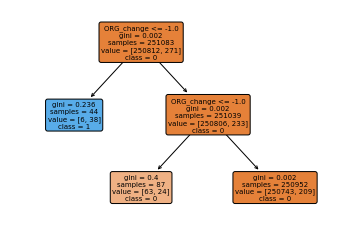

In [30]:
a = plot_tree(clf, 
              feature_names=['amount','ORG_change','DEST_change'], 
              class_names=['0','1'], 
              filled=True, 
              rounded=True, 
              fontsize=7)

In [31]:
print(clf.feature_importances_)
print(X.columns)
print('上面这个模型并没有解释效力 基本不用看 关键是下面的随机森林的结果')
print('上面的代码的作用是把树给可视化')

[0. 1. 0.]
Index(['amount', 'ORG_change', 'DEST_change'], dtype='object')
上面这个模型并没有解释效力 基本不用看 关键是下面的随机森林的结果
上面的代码的作用是把树给可视化


## 模型的效用评估 

Score is 0.9991536730589242
AUC score is 0.9512071203432365
roc auc is :0.9512071203432365


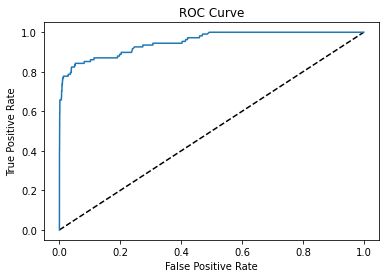

In [32]:
clf = RandomForestClassifier(n_estimators=300, max_depth=5,random_state=0)
clf.fit(X_train, y_train)

y_pred_pca = clf.predict(X_test)
score = accuracy_score(y_test, y_pred_pca)
print("Score is "+ str(score))
# Generating the ROC curve
y_pred_proba_pca = clf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_pca)
roc_auc = auc(fpr, tpr)
print("AUC score is " + str(roc_auc))

# Plot ROC curve
print("roc auc is :" + str(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')  # plot the line at diagnol
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

上图是模型在测试集上的效果，表示正确率上升的很快，同时AUC也很高，表明我们的模型很有效

In [33]:
print(clf.feature_importances_)
print(X.columns)

[0.21998392 0.65217118 0.12784489]
Index(['amount', 'ORG_change', 'DEST_change'], dtype='object')


## 5.总结与分析
#### 我们通过最开始对金融事务本身理解做出逻辑推断，结合统计分析的结果得出了以下重要的事实：
1. 只有转出交易存在欺诈
2. 夜间欺诈发生率相对较高，源于夜间交易较少，但是在实际模型中，该特征的效力也不强
3. 欺诈的转入账户往往金额为0  转出账户往往转出后金额为0
***

#### 随后我们做出了如下处理
1. 丢弃其他交易性质的数据，仅仅保留转出记录数据
2，构建夜间种类变量
3. 构建转入率 转出率相对指标衡量交易性质
4. 测试集训练集划分
***

#### 最后我们用一颗枝丫较短的决策树来辅助逻辑解释，用随机森林模型做预测和模型诊断
1. 从决策树上我们看到，转入账户余额越小越可能是诈骗，诈骗犯账户不留钱
2. 诈骗往往将受害人账户钱全部转出
3. 夜间往往是高发
4. 以这些特征做的随机森林模型在占比33%的测试集上表现极好